In [1]:
import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Добавляем путь к корневой папке проекта
sys.path.append(os.path.abspath(os.path.join('..')))

from utils import calc_metrics

num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

In [2]:
X = pd.read_csv('../data/x.csv', index_col='date')
y = pd.read_csv('../data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('../metrics.csv', index_col=0)

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

tf_idf = vectorizer.transform(X.release)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import optuna

In [ ]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 3, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 25),
    }

    estimator = LogisticRegression(penalty='l1', solver='liblinear', C=params['C'], max_iter=1000, random_state=42)
    selector = SelectFromModel(estimator)

    pipeline = Pipeline([
        ('selector', selector),
        ('model', RandomForestClassifier(max_depth=params['max_depth'], random_state=42, n_jobs=-1))
    ])

    metric, _ = calc_metrics(
        tf_idf, y, 
        pipeline, 
        name=' ',
        plot=False
    )

    return metric

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

In [49]:
study.best_params

{'C': 364.8560066442843, 'max_depth': 9}

In [53]:
estimator = LogisticRegression(penalty='l1', solver='liblinear', C=364.8560066442843, random_state=42)
selector = SelectFromModel(estimator)

pipeline = Pipeline([
    ('selector', selector),
    ('model', RandomForestClassifier(max_depth=9, random_state=42))
])

              precision    recall  f1-score   support

        -1.0       0.73      0.70      0.71        23
         0.0       0.52      0.65      0.58        26
         1.0       0.77      0.53      0.62        19

    accuracy                           0.63        68
   macro avg       0.67      0.63      0.64        68
weighted avg       0.66      0.63      0.64        68



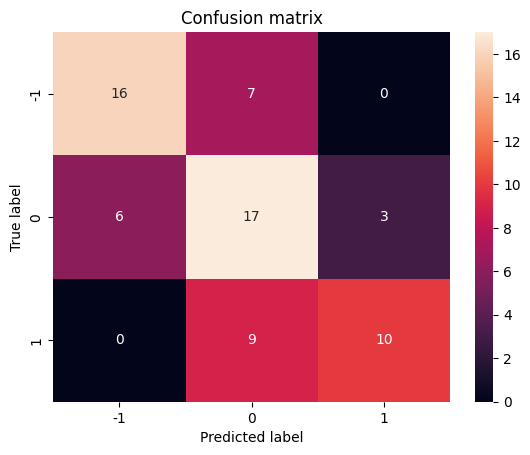

In [54]:
metric, model = calc_metrics(
    tf_idf, y, 
    pipeline, 
    name=' ', 
)

In [55]:
metric

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
,0.632353,0.637461,0.625271,0.670552,0.780721,0.786628
